In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import scipy.stats

In [2]:
from GeneTEA.eval.plotting import *
from GeneTEA.eval.benchmarking_tests import find_nearest_neighbors, gen_knn_graph
from GeneTEA.utils import download_to_cache_ext
from GeneTEA.train import load_models
genetea = load_models("../trained_models", name='GeneTEA')
yeast_tea = load_models("../trained_models", name='GeneTEA-yeast')
pharm_tea = load_models("../trained_models", name='PharmaTEA')

# Replace paths below

Note: download_to_cache_ext is a wrapper function to get a local filepath.

In [3]:
v=24
FILEPATHS = {
    "hgnc_mapping":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/hgnc_complete_set_2024-01-01", ext="txt"),
    "orthologs":download_to_cache_ext(f"genetea-manuscript-bb10.{v}/ORTHOLOGY-ALLIANCE_COMBINED", ".tsv"),
    "portal_compounds":"../../manuscript-resources/PortalCompounds.csv",
    "prism_repurposing":"../../manuscript-resources/Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv",
    "hot_spot":"../../manuscript-resources/OmicsSomaticMutationsMatrixHotspot.csv"
}

In [4]:
hgnc_mapping = pd.read_csv(FILEPATHS["hgnc_mapping"], low_memory=False, sep="\t")
protein_coding = hgnc_mapping.loc[hgnc_mapping["locus_group"] == "protein-coding gene", "symbol"]

syns = genetea.synonyms.explode()
all_terms_to_syns = pd.concat([genetea.terms.to_series(), pd.Series(syns.index, syns.values)])
protein_coding_gene_terms = all_terms_to_syns.loc[lambda x: x.index.isin(protein_coding)].unique()

In [5]:
ks = [1, 5, 10, 20, 50, 100]

# GeneTEA-yeast

In [6]:
%%time

overlap_terms = list((set(yeast_tea.terms) & set(genetea.terms)) - set(protein_coding_gene_terms))
print("Terms", len(overlap_terms))

orthologs = pd.read_csv(FILEPATHS["orthologs"], index_col=None, sep="\t", skiprows=15)
yeast_human_orthologs = orthologs.loc[
    (orthologs["Gene1SpeciesName"] == "Homo sapiens")
    & (orthologs["Gene2Symbol"].isin(genetea.entities))
    & (orthologs["Gene2SpeciesName"] == "Saccharomyces cerevisiae")
    & (orthologs["Gene2Symbol"].isin(yeast_tea.entities))
    & (orthologs["IsBestScore"] == "Yes") & (orthologs["IsBestRevScore"] == "Yes")    
    & (orthologs["AlgorithmsMatch"] == orthologs["OutOfAlgorithms"])
].groupby("Gene2Symbol")["Gene1Symbol"].apply(lambda x: list(x.drop_duplicates()))
print("Mapping", len(yeast_human_orthologs))

yeast_tfidfs, yeast_terms, yeast_genes = yeast_tea.get_subset_tfidfs(terms=overlap_terms, entities=yeast_human_orthologs.index)
human_tfidfs, human_terms, human_genes = genetea.get_subset_tfidfs(terms=overlap_terms, entities=protein_coding)

yeast_nbrs, yeast_match_knn, yeast_frac_knn = find_nearest_neighbors(
    human_tfidfs, yeast_tfidfs, human_genes, yeast_genes, yeast_human_orthologs, ks=ks
)

Terms 4868
Mapping 212
testing ks [1, 5, 10, 20, 50, 100]
k 1
k 5
k 10
k 20
k 50
k 100
CPU times: user 4min 27s, sys: 9.69 s, total: 4min 36s
Wall time: 4min 40s


/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_71506/774518685.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig5b.jpg", bbox_inches="tight")
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


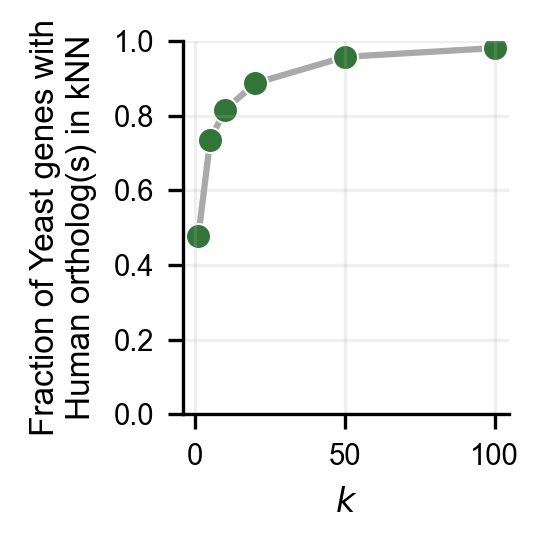

,k,Fraction
0,1,0.476415
1,5,0.735849
2,10,0.816038
3,20,0.886792
4,50,0.957547
5,100,0.981132


In [7]:
YEAST = PALETTE[7]
plt.figure(figsize=(1.84,1.84))
sns.lineplot(data=yeast_frac_knn, x="k", y="Fraction", color="darkgrey", zorder=-1)
sns.scatterplot(data=yeast_frac_knn, x="k", y="Fraction", color=YEAST)
plt.xlabel("$k$")
plt.ylabel("Fraction of Yeast genes with\nHuman ortholog(s) in kNN")
plt.ylim(0,1)
plt.grid(alpha=0.2)
plt.savefig("../../figure-panels/Fig5b.jpg", bbox_inches="tight")
plt.show()
yeast_frac_knn

# PharmTEA

In [8]:
compound = pd.read_csv(FILEPATHS["portal_compounds"]).dropna(subset=["PubChemCID", "GeneSymbolOfTargets"])
compound["PubChemCID"] = compound["PubChemCID"].astype(int).astype(str)
compound.set_index("PubChemCID", inplace=True)

In [9]:
overlap_terms = list((set(pharm_tea.terms) & set(genetea.terms)) - set(protein_coding_gene_terms))


pharm_tfidfs, pharm_terms, drugs = pharm_tea.get_subset_tfidfs(terms=overlap_terms, entities=compound.index)
gene_tfidfs, gene_terms, genes = genetea.get_subset_tfidfs(terms=overlap_terms, entities=protein_coding)
print("Terms", len(pharm_terms), "Drugs", len(drugs), "Genes", len(genes))

drug_to_target = compound.loc[drugs, "GeneSymbolOfTargets"].str.split(";").explode().str.strip().explode().str.strip()
drug_to_target = drug_to_target.groupby(drug_to_target.index).apply(list)

nbrs, drug_match_knn, drug_frac_knn = find_nearest_neighbors(gene_tfidfs, pharm_tfidfs, genes, drugs, drug_to_target, ks=ks)

Terms 5956 Drugs 151 Genes 19258
testing ks [1, 5, 10, 20, 50, 100]
k 1
k 5
k 10
k 20
k 50
k 100


/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_71506/2933047833.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig5d.jpg", bbox_inches="tight")
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


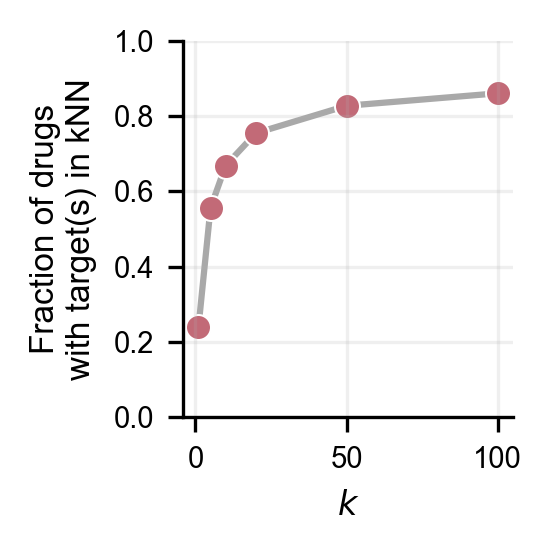

,k,Fraction
0,1,0.238411
1,5,0.556291
2,10,0.668874
3,20,0.754967
4,50,0.827815
5,100,0.860927


In [10]:
PHARMA = PALETTE[5]
plt.figure(figsize=(1.85, 1.85))
sns.lineplot(data=drug_frac_knn, x="k", y="Fraction", color="darkgrey", zorder=-1)
sns.scatterplot(data=drug_frac_knn, x="k", y="Fraction", color=PHARMA)
plt.xlabel("$k$")
plt.ylabel("Fraction of drugs\nwith target(s) in kNN")
plt.ylim(0,1)
plt.grid(alpha=0.2)
plt.savefig("../../figure-panels/Fig5d.jpg", bbox_inches="tight")
plt.show()
drug_frac_knn

In [11]:
G = gen_knn_graph(nbrs, gene_tfidfs, pharm_tfidfs, genes, drugs, k=5)
cc = list(nx.connected_components(G))
pos = nx.spring_layout(G, seed=27)
positions = pd.DataFrame(pos).T.merge(compound, left_index=True, right_index=True, how="left")
positions["Category"] = "Gene"
positions.loc[drugs, "Category"] = "Drug"

In [12]:
parp_family = hgnc_mapping.set_index("symbol")["gene_group"].str.contains("Poly(ADP-ribose) polymerases", regex=False).replace(
    {True:"PARP family gene", False:"Other gene"}
).fillna("Other gene")

/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_71506/3538568585.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig5e.jpg", bbox_inches="tight")
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


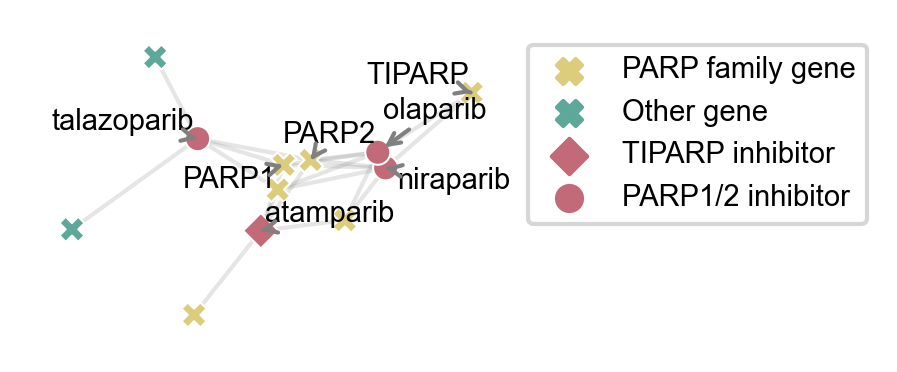

In [13]:
parp1 = [c for c in cc if "PARP1" in c][0]
zoom_in = positions.loc[parp1].fillna("Gene")
zoom_in["ParpFamily"] = parp_family.reindex(zoom_in.index).fillna("_Drug")
zoom_in["Inhibitor"] = zoom_in["TargetOrMechanism"].replace({
    "inhibitor of PARP1 and PARP2":"PARP1/2 inhibitor", 
    "inhibitor of PARP7 (TIPARP)":"TIPARP inhibitor"
})
targets = zoom_in["GeneSymbolOfTargets"].str.split(";").explode().unique()

plt.figure(figsize=(3,1.25), dpi=300)
e = nx.draw_networkx_edges(G.subgraph(parp1), pos, edge_color="grey", ax=plt.gca(), alpha=0.2)
s1 = sns.scatterplot(
    data=zoom_in.query("Category == 'Gene'"), x=0, y=1, hue="ParpFamily", style="ParpFamily", markers=["X", "X"], 
    palette=[PALETTE[3], PALETTE[0]], hue_order=["PARP family gene", "Other gene"]
)
s2 = sns.scatterplot(data=zoom_in.query("Category == 'Drug'"), x=0, y=1, hue="Inhibitor",  style="Inhibitor", 
                markers=["D", "o"], palette=[PHARMA, PHARMA])
plt.legend(loc="upper left", bbox_to_anchor=(1,1), ncols=1)
texts = []
for i, row in zoom_in.loc[zoom_in.index.isin(targets)].iterrows():
    texts.append(plt.gca().text(row[0], row[1], i, clip_on=False))
for i, row in zoom_in.loc[zoom_in.index.isin(drugs)].iterrows():
    texts.append(plt.gca().text(row[0], row[1], row["CompoundName"].lower(), clip_on=False))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="grey"))
plt.gca().set_axis_off()
plt.savefig("../../figure-panels/Fig5e.jpg", bbox_inches="tight")
plt.show()

In [14]:
prism_rep = pd.read_csv(FILEPATHS["prism_repurposing"], index_col=0)
prism_rep = prism_rep.merge(
    compound.explode("SampleIDs")[["SampleIDs"]], how="inner", left_index=True, right_on="SampleIDs"
).drop(columns="SampleIDs").loc[lambda x: x.index.isin(drugs)]

In [15]:
hs = pd.read_csv(FILEPATHS["hot_spot"], index_col=0)
is_mut = prism_rep.loc[:, hs["KRAS (3845)"].reindex(prism_rep.columns) > 0]
not_mut = prism_rep.loc[:, hs["KRAS (3845)"].reindex(prism_rep.columns) == 0]
print(is_mut.shape, not_mut.shape)

ttest_res = scipy.stats.ttest_ind(is_mut, not_mut, axis=1, nan_policy="omit")
sig = pd.DataFrame({"p-val":ttest_res.pvalue, "mean_diff":is_mut.mean(axis=1)-not_mut.mean(axis=1)}, index=is_mut.index)
non_na_p  = sig["p-val"].dropna()
sig["FDR"] = pd.Series(scipy.stats.false_discovery_control(non_na_p), index=non_na_p.index)
sig["-log10FDR"] = -np.log10(sig["FDR"])
diff_compounds = sig.loc[lambda x: x["FDR"] < 0.05, "mean_diff"].sort_values()

(64, 159) (64, 749)


/var/folders/8g/bm84gl3102v3fy4htn8rpv340000gp/T/ipykernel_71506/2876965750.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figure-panels/Fig5f.jpg", bbox_inches="tight")
/opt/anaconda3/envs/genetea-test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


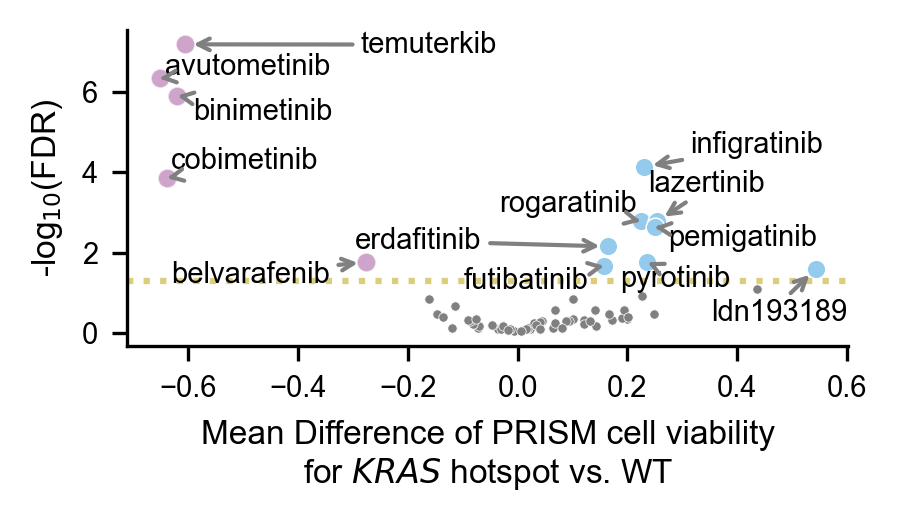

In [16]:
plt.figure(figsize=(3,1.75), dpi=300)
sns.scatterplot(data=sig.loc[sig["FDR"] > 0.05], y="-log10FDR", x="mean_diff", s=5, color="grey")
sns.scatterplot(data=sig.loc[(sig["FDR"] < 0.05) & (sig["mean_diff"] < 0)], y="-log10FDR", x="mean_diff", s=20, color=PALETTE[6], alpha=0.5)
sns.scatterplot(data=sig.loc[(sig["FDR"] < 0.05) & (sig["mean_diff"] > 0)], y="-log10FDR", x="mean_diff", s=20, color=PALETTE[4])
plt.axhline(-np.log10(0.05), color=PALETTE[3], linestyle=":")
plt.ylabel(r"-log$_{10}$(FDR)")
plt.xlabel("Mean Difference of PRISM cell viability\nfor $KRAS$ hotspot vs. WT")
texts = []
for cid, row in sig.loc[(sig["FDR"] < 0.05)].iterrows():
    texts.append(plt.gca().text(row["mean_diff"], row["-log10FDR"], compound["CompoundName"].str.lower()[cid], ))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="grey"))
plt.savefig("../../figure-panels/Fig5f.jpg", bbox_inches="tight")
plt.show()

In [17]:
pharm_tea.get_enriched_terms(diff_compounds.index[diff_compounds < 0], plot=False, n=2, group_subterms=False, background=drugs)

,Term,n Matching Drugs Overall,n Matching Drugs in List,p-val,FDR,Stopword,Matching Drugs in List,Synonyms,Total Info,Effect Size,Term Group
0,~ raf,12,4.0,1.137466e-04,0.027906,False,10288191 16222096 16719221 89655386,RAF;raf,3.775702,1.246559,~ raf|~ MEK|~ ras++
1,~ mitogen activated protein kinase,9,5.0,2.059294e-07,0.000227,False,10288191 121408882 16222096 16719221 89655386,kinase mitogen activated protein;mitogen activ...,1.800024,1.008609,~ mitogen activated protein kinase|EC 2 7 11 24++


In [18]:
pharm_tea.get_enriched_terms(diff_compounds.index[diff_compounds > 0], plot=False, n=2, group_subterms=False, background=drugs)

,Term,n Matching Drugs Overall,n Matching Drugs in List,p-val,FDR,Stopword,Matching Drugs in List,Synonyms,Total Info,Effect Size,Term Group
0,~ FGFR,6,5.0,5.397418e-07,0.001192,False,53235510 67462786 71611869 71621331 86705695,FGFR;FGFRs;FGFR family;fibroblast growth facto...,2.405102,2.282382,~ FGFR
